<a href="https://colab.research.google.com/github/wfwiggins/RSNA-Image-AI-2020/blob/master/RSNA20_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **RSNA 2020: Interactive AI for Non-coders**

## **Image Classification Basics for Beginners**

This work is adapted from Lakhani et al. "Hello World Deep Learning in Medical Imaging." Journal of Digital Imaging. 2018 Jun;31(3):283-289 ([link to article](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5959832/)). Data were obtained and the notebook adapted from Paras Lakhani's GitHub repository ([link to repo](https://github.com/paras42/Hello_World_Deep_Learning/tree/9921a12c905c00a88898121d5dc538e3b524e520)). Code has been modified to match the format and directory structure from the article. Additional modifications have been made with the intent to increase readability and facilitate understanding for participants at all levels of coding skill and experience.

To explore this model and data set, please _Save a Copy in Drive_ from the `File` menu above (i.e. save a copy in your Google Drive).

# System Setup & Downloading the Data
For the experiments that follow, we'll use the [**Python** programming language](https://www.python.org/) with the [**fast.ai**](https://fast.ai/) API, built on top of the [**PyTorch**](https://pytorch.org/) **library**.

In [ ]:
#@title **Setting up the runtime environment...**
#@markdown Running this cell will install the necessary libraries, download the data and restart the session.
#@markdown This will generate an error message, which we can safely ignore.

import os

!pip install fastai --upgrade >/dev/null

# **Downloading the data...**

!wget -q https://github.com/wfwiggins/RSNA-Image-AI-2020/blob/master/data.zip?raw=true
!mkdir -p data
!unzip -o data.zip?raw=true -d data >/dev/null
!rm data.zip?raw=true

os.kill(os.getpid(), 9)

# Exploring the Data
Let's take a look at the directory structure and contents, then create some variables to help us as we proceed.

In [1]:
#@title Directory structure

from fastai.basics import *
from fastai.vision.all import *

import warnings
warnings.simplefilter('ignore')

# Set path variable to the directory where the data is located
path = Path('/content/data')

# Command line "magic" command to show directory contents
!ls {path}/**/*


/content/data/test/abd:
abd_test.png

/content/data/test/chest:
chest_test.png

/content/data/train/abd:
abd0.png   abd14.png  abd19.png  abd23.png  abd28.png  abd3.png  abd8.png
abd10.png  abd15.png  abd1.png	 abd24.png  abd29.png  abd4.png  abd9.png
abd11.png  abd16.png  abd20.png  abd25.png  abd2.png   abd5.png
abd12.png  abd17.png  abd21.png  abd26.png  abd30.png  abd6.png
abd13.png  abd18.png  abd22.png  abd27.png  abd31.png  abd7.png

/content/data/train/chest:
chst33.png  chst39.png	chst45.png  chst51.png	chst57.png  chst63.png
chst34.png  chst40.png	chst46.png  chst52.png	chst58.png  chst64.png
chst35.png  chst41.png	chst47.png  chst53.png	chst59.png  chst65.png
chst36.png  chst42.png	chst48.png  chst54.png	chst60.png
chst37.png  chst43.png	chst49.png  chst55.png	chst61.png
chst38.png  chst44.png	chst50.png  chst56.png	chst62.png

/content/data/val/abd:
abd0.png  abd1.png  abd2.png  abd3.png	abd4.png

/content/data/val/chest:
chst0.png  chst1.png  chst2.png  chst3.png  chst4.pn

As you can see, the `data` directory contains subdirectories `train`, `val` and `test`, which contain the *training*, *validation* and *test* data for our experiment. `train` and `val` contain subdirectories `abd` and `chest` containing abdominal and chest radiographs for each data set. There are 65 training images and 10 validation images with *balanced distributions* over our *target classes* (i.e. approximately equal numbers of abdominal and chest radiographs in each data set and optimized for a classification problem). 

# Model Training Setup

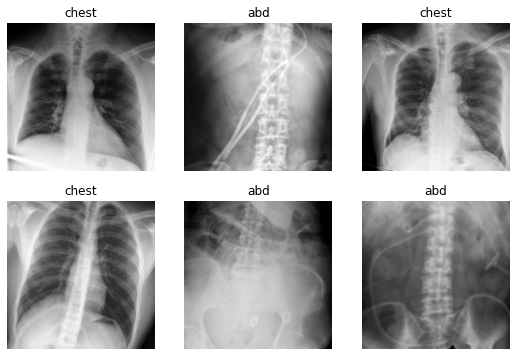

In [2]:
#@title Load the image data into DataLoaders

#@markdown This step loads the data for the training and validation datasets into a PyTorch `DataLoader` object.
#@markdown The `fastai` library includes functionality to apply _transformations_ to the image data for data augmentation.
#@markdown When training a model, the `DataLoader` will present data to the model in _batches_ with these transformations randomly applied.
#@markdown Transformations can include rotation, translation, flipping, rescaling, etc. 
#@markdown These are methods of augmentation, which increase the unique data that the model can be exposed to. 

#@markdown After you run this cell, a batch of data will be shown with augmentation transforms applied.

dls = ImageDataLoaders.from_folder(path, valid='val', seed=42, item_tfms=Resize(460), batch_tfms=aug_transforms(size=224, min_scale=0.75), bs=16)
dls.show_batch(max_n=6)

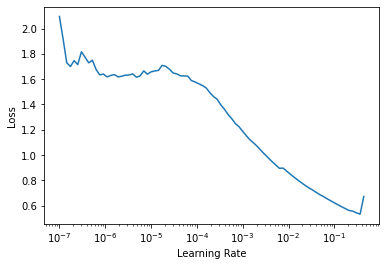

In [3]:
#@title Find the optimal learning rate

#@markdown The learning rate is a hyperparameter that controls how much your model adjusts in response to percieved error after each training epoch. Choosing an optimal learning rate is an optimal step in model training.

#@markdown From the `fastai` [docs](https://docs.fast.ai/callback.schedule#Learner.lr_find):
#@markdown > First introduced by Leslie N. Smith in [Cyclical Learning Rates for Training Neural Networks](https://arxiv.org/pdf/1506.01186.pdf), the `LRFinder` trains the model with exponentially growing learning rates and stops in case of divergence.
#@markdown > The losses are then plotted against the learning rates with a log scale. <br><br>
#@markdown > A good value for the learning rates is then either:
#@markdown > - 1/10th of the minimum before the divergence
#@markdown > - where the slope is the steepest

#@markdown When you run this cell for the first time in a session, it will download a pretrained version of the model to your workspace before running the `LRFinder`.

learn = cnn_learner(dls, resnet18, metrics=accuracy, seed=42)
learn.lr_find();

# Transfer Learning

Deep learning requires large amounts of training data to successfully train a model.

When we don't have enough data to work with for the planned task, starting with a _pre-trained_ network that has been optimally trained on another task can be helpful. The concept of re-training a pre-trained network for a different task is called _transfer learning_.

## Fine-tuning

In the process of re-training the model, we start by changing the final layers of the network to define the output or predictions our model will make. In order to avoid propagating too much error through the rest of the network during the initial training, we freeze the other layers of the network for the first cycle or _epoch_ of training. Next, we open up the rest of the network for training and train for a few more _epochs_. This process is called _fine-tuning_.

## Epochs and data augmentation

During each epoch, the model will be exposed to the entire dataset. Each batch of data will have our data transformations randomly applied in order to provide data augmentation. This helps to ensure that our model never sees the exact same image twice. This is important because we wouldn't want our model to simply memorize the training dataset and not converge on a generalized solution, resulting in poor performance on the validation dataset.

## The loss function

In a classification task, you're either right or wrong. This binary information doesn't give us much nuance to work with when training a model. A _loss function_ give us a numeric estimation of "how wrong" our model is. This gives us a target to optimize during the training process.

When reviewing the results of successive epochs in training, the loss on your validation dataset should always be **decreasing**. When it starts to increase, that is a sign of your model _overfitting_ to the training dataset.

In [4]:
#@title Fine-tune the model

#@markdown First, choose the number of epochs for which you will train your model.
#@markdown Then, choose a base learning rate based on the results in the `LRFinder` plot above.

#@markdown Finally, run the cell to train the model.
#@markdown After you've seen the results of your experiment, you can re-run this cell with different hyperparameters to see how they affect the result.

epochs = 5 #@param {type: "integer"}
base_lr = 2e-3 #@param {type: "number"}

learn = cnn_learner(dls, resnet18, metrics=accuracy, seed=42)
learn.fine_tune(epochs, base_lr=base_lr)

epoch,train_loss,valid_loss,accuracy,time
0,1.125812,1.007721,0.600000,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.219310,0.829025,0.600000,00:01
1,0.124547,0.654897,0.800000,00:01
2,0.081155,0.284275,0.900000,00:01
3,0.059225,0.123658,0.900000,00:01
4,0.053050,0.070862,0.900000,00:01


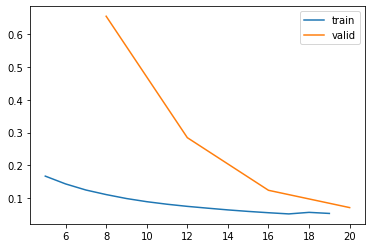

In [5]:
#@title Review training curves

#@markdown The visual representation of the training and validation losses are useful to evaluate how successfully you were able to train your model.

learn.recorder.plot_loss()

# Testing the Model

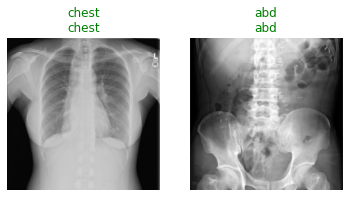

In [6]:
#@title **Test the model on the test dataset**

#@markdown When you run this cell, the first line shows the groundtruth for whether the radiograph is of the chest or abdomen.
#@markdown The second line is the model prediction for whether the image ia a chest or abdominal radiograph.

# !mkdir data/test/abd
# !mkdir data/test/chst
# !mv data/test/abd_test.png data/test/abd
# !mv data/test/chest_test.png data/test/chst

test_files = get_image_files(path/'test')
test_dl = learn.dls.test_dl(test_files, with_labels=True)
learn.show_results(dl=test_dl)

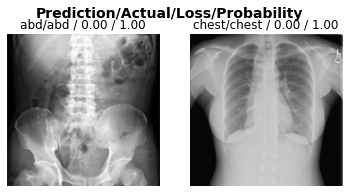

In [7]:
#@title **A little more detail on the predictions**

#@markdown Running this cell will provide us with the loss on each image, as well as the model's predicted probability, which can be thought of as the model's confidence in its prediction.
#@markdown If the model is completely confident, the loss will be "0.00" and the probability will be "1.00".

interp = ClassificationInterpretation.from_learner(learn, dl=test_dl)
interp.plot_top_losses(k=2)

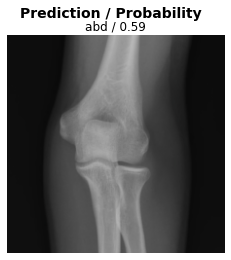

In [8]:
#@title **Test the model on a surprise example**

#@markdown Here, we present the model with an unexpected image and see how it responds. 

y = get_image_files(path, recurse=False)
test_dl = learn.dls.test_dl(y)
x, = first(test_dl)
res = learn.get_preds(dl=test_dl, with_decoded=True)
x_dec = TensorImage(dls.train.decode((x,))[0][0])
fig, ax = plt.subplots()
fig.suptitle('Prediction / Probability', fontsize=14, fontweight='bold')
x_dec.show(ctx=ax)
ax.set_title(f'{dls.vocab[res[2][0]]} / {max(res[0][0]):.2f}');

When presented with this radiograph of an elbow, the model makes a prediction but is less confident than with the other test images.

This is an important point to consider for two reasons:
1. A deep learning model can only learn what we teach it to learn
2. In designed our model implementation, we might consider designing a pre-processing step in which the data (or metadata) is checked to ensure the input to the model is valid. This is an important practical consider for AI applications in radiology.

# Visualizing Model Inferences

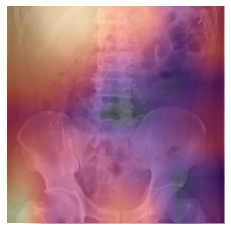

In [9]:
#@title **Class activation map (CAM)**

#@markdown CAM allows one to visualize which regions of the original image are heavily weighted in the prediction of the corresponding class. 
#@markdown This technique provides a visualization of the activations in the **final** _convolutional_ block of a Convolutional Neural Network (CNN).

#@markdown CAM is also useful to determine if the model is "cheating" and looking somewhere it shouldn't be to make its prediction (i.e. radioopaque markers placed by the technologist).

#@markdown > Choose which of the two test images you would like to examine and run this cell to see the CAM output overlayed on the input image.

test_case = 'abd' #@param ['abd', 'chest']
cls = 0 if test_case == 'abd' else 1
label = test_case

y = get_image_files(path/'test'/label)
test_dl = learn.dls.test_dl(y, with_labels=True)

hook = hook_output(learn.model[0])
x, _ = first(test_dl)
with torch.no_grad(): output = learn.model.eval()(x)
act = hook.stored[0]
cam_map = torch.einsum('ck,kij->cij', learn.model[1][-1].weight, act)
x_dec = TensorImage(dls.train.decode((x,))[0][0])
_, ax = plt.subplots()
x_dec.show(ctx=ax)
ax.imshow(cam_map[cls].detach().cpu(), alpha=0.6, extent=(0,224,224,0),
              interpolation='bilinear', cmap='magma');
hook.remove()

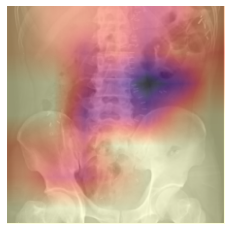

In [10]:
#@title **Grad-CAM**

#@markdown Gradient-weighted CAM (Grad-CAM) allows us to visualize the output from _any convolutional block_ in a CNN.

#@markdown By default, this cell is setup to show the Grad-CAM output from the final convolutional block in the CNN, for comparison to the CAM output.

#@markdown > Choose which of the two test images you would like to examine and run this cell to see the Grad-CAM output overlayed on the input image.
#@markdown >
#@markdown > Next, select a _different_ block and re-run the cell to see how the output changes for different blocks in the network.

test_case = 'abd' #@param ['abd', 'chest']

cls = 0 if test_case == 'abd' else 1
label = test_case

y = get_image_files(path/'test'/label)
test_dl = learn.dls.test_dl(y, with_labels=True)
x, _ = first(test_dl)
mod = learn.model[0]

block = -1 #@param {type: "slider", min: -8, max: -1, step: 1}

hook_func = lambda m,i,o: o[0].detach().clone()

with Hook(mod[block], hook_func, is_forward=False) as hookg:
    with Hook(mod[block], hook_func) as hook:
        output = learn.model.eval()(x.cuda())
        act = hook.stored
    output[0, cls].backward()
    grad = hookg.stored

w = grad[0].mean(dim=[1,2], keepdim=True)
cam_map = (w * act[0]).sum(0)
x_dec = TensorImage(dls.train.decode((x,))[0][0])
_, ax = plt.subplots()
x_dec.show(ctx=ax)
ax.imshow(cam_map.detach().cpu(), alpha=0.6, extent=(0,224,224,0),
              interpolation='bilinear', cmap='magma');